# CPSC 340 Assignment 6

In [52]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb

%matplotlib inline

from scipy.sparse import csr_matrix as sparse_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

## Instructions
rubric={mechanics:5}


The above points are allocated for following the [homework submission instructions](https://github.ugrad.cs.ubc.ca/CPSC340-2017W-T2/home/blob/master/homework_instructions.md).

## Exercise 1: Finding similar items

For this question we'll be using the [Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/). The author of the data set has asked for the following citations:

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

We will focus on the "Patio, Lawn, and Garden" section. Download the [ratings](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv) and place the file in the `data` directory with the original filename. Once you do that, the code below should load the data:

In [53]:
filename = "ratings.csv"

with open(os.path.join("..", "data", filename), "rb") as f:
    ratings = pd.read_csv(f,names=("user","item","rating","timestamp"))
ratings.head()

,user,item,rating,timestamp
0,A2VNYWOPJ13AFP,0981850006,5.0,1259798400
1,A20DWVV8HML3AW,0981850006,5.0,1371081600
2,A3RVP3YBYYOPRH,0981850006,5.0,1257984000
3,A28XY55TP3Q90O,0981850006,5.0,1314144000
4,A3VZW1BGUQO0V3,0981850006,5.0,1308268800


We'd also like to construct the user-product matrix `X`. Let's see how big it would be:

In [54]:
def get_stats(ratings, item_key="item", user_key="user"):
    print("Number of ratings:", len(ratings))
    print("The average rating:", np.mean(ratings["rating"]))

    d = len(set(ratings[item_key]))
    n = len(set(ratings[user_key]))
    print("Number of users:", n)
    print("Number of items:", d)
    print("Fraction nonzero:", len(ratings)/(n*d))
    print("Size of full X matrix: %.2f GB" % ((n*d)*8/1e9))

    return n,d

n,d = get_stats(ratings)

Number of ratings: 993490
The average rating: 4.006400668350965
Number of users: 714791
Number of items: 105984
Fraction nonzero: 1.3114269915944552e-05
Size of full X matrix: 606.05 GB


600 GB! That is way too big. We don't want to create that matrix. On the other hand, we see that we only have about 1 million ratings, which would be around 8 MB ($10^6$ numbers $\times$ at 8 bytes per double precision floating point number). Much more manageable. 

In [55]:
def create_X(ratings,n,d,user_key="user",item_key="item"):
    user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(n))))
    item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(d))))

    user_inverse_mapper = dict(zip(list(range(n)), np.unique(ratings[user_key])))
    item_inverse_mapper = dict(zip(list(range(d)), np.unique(ratings[item_key])))

    user_ind = [user_mapper[i] for i in ratings[user_key]]
    item_ind = [item_mapper[i] for i in ratings[item_key]]

    X = sparse_matrix((ratings["rating"], (user_ind, item_ind)), shape=(n,d))
    
    return X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind

X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind = create_X(ratings, n, d)

In [56]:
print(item_mapper['0981850006']) #returns the index of this rating
print(user_inverse_mapper[0]) #returns the user ID
print(item_inverse_mapper[0]) #returns the rating at that index

#print(item_inverse_mapper[4710])

#print(item_mapper['17777']) 
print(X)

# sanity check

print(X.shape) # should be number of users by number of items
print(X.nnz)   # number of nonzero elements -- should equal number of ratings

0
A0001528BGUBOEVR6T5U
0981850006
  (0, 17777)	2.0
  (1, 4710)	5.0
  (2, 28823)	4.0
  (2, 64502)	5.0
  (3, 400)	4.0
  (4, 80402)	3.0
  (5, 22427)	5.0
  (6, 17300)	5.0
  (6, 19950)	5.0
  (7, 80602)	1.0
  (8, 61229)	5.0
  (9, 85209)	5.0
  (10, 4872)	5.0
  (11, 54701)	5.0
  (12, 25476)	5.0
  (13, 32906)	3.0
  (14, 12981)	1.0
  (15, 6732)	5.0
  (15, 7598)	4.0
  (15, 47818)	5.0
  (16, 39187)	2.0
  (16, 45095)	5.0
  (17, 67459)	2.0
  (18, 65292)	5.0
  (19, 27459)	5.0
  :	:
  (714771, 93132)	5.0
  (714772, 10751)	5.0
  (714772, 14572)	5.0
  (714773, 15913)	5.0
  (714774, 27243)	5.0
  (714775, 9543)	5.0
  (714776, 58363)	5.0
  (714777, 11158)	4.0
  (714778, 83566)	1.0
  (714779, 493)	5.0
  (714779, 1898)	3.0
  (714780, 15979)	5.0
  (714781, 49908)	5.0
  (714781, 85010)	5.0
  (714782, 12292)	5.0
  (714783, 73345)	5.0
  (714784, 2378)	1.0
  (714785, 26050)	5.0
  (714785, 34895)	5.0
  (714786, 5615)	1.0
  (714787, 93840)	5.0
  (714788, 70606)	5.0
  (714789, 53699)	4.0
  (714790, 63678)	5.0
  (714

In [57]:
X.data.nbytes

7947920

(Above: verifying our estimate of 8 MB to store sparse `X`)

### 1.1
rubric={reasoning:2}

Find the following items:

1. the item with the most reviews
2. the item with the most total stars
3. the item with the highest average stars

Then, find the names of these items by looking them up with the url https://www.amazon.com/dp/ITEM_ID, where `ITEM_ID` is the id of the item.

In [58]:
url_amazon = "https://www.amazon.com/dp/%s"
#a.max, want the one with the most revies

# example:
print(url_amazon % 'B00CFM0P7Y')

https://www.amazon.com/dp/B00CFM0P7Y


In [59]:
#1.# times it shows up - want the maximum amount
user_ind[0]
item_ind[4781]

array = []
array = X.getnnz(axis=0)
#print(array) #amount of ratings per item

ind = np.argmax(array) #index of the item with the most ratings
#print(array[ind])  #amount of ratings of the item

itemid = item_inverse_mapper[ind] #item that is most rated
print(url_amazon % itemid)

https://www.amazon.com/dp/B000HCLLMM


In [60]:
#2.#item with the most total stars:

array_stars = np.sum(X, axis=0) #array of the sum of the stars
ind = np.argmax(array_stars)
itemid = item_inverse_mapper[ind]
print(url_amazon % itemid)

https://www.amazon.com/dp/B000HCLLMM


In [61]:
#3.divide by ratings
array_stars = np.sum(X, axis=0) #array of the stars per item
array_ratings = X.getnnz(axis=0) # of ratings_array
division_array = np.divide(array_stars, array_ratings)
ind = np.argmax(division_array)

itemid = item_inverse_mapper[ind] #item that is most rated
print(url_amazon % itemid)

https://www.amazon.com/dp/0981850006


### 1.2
rubric={reasoning:2}

Make the following histograms 

1. The number of ratings per user
2. The number of ratings per item
3. The ratings themselves

For the first two, use
```
plt.yscale('log', nonposy='clip')
``` 
to put the histograms on a log-scale.

[1 1 2 ... 1 1 2]


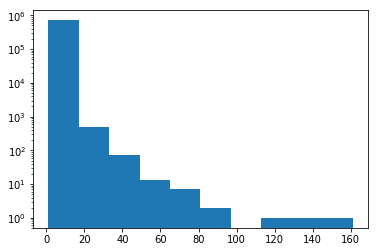

In [62]:
#1.Number of ratings per user
array = X.getnnz(axis=1)
print(array)
plt.hist(array)
plt.yscale('log', nonposy='clip')

[7 3 2 ... 6 5 5]


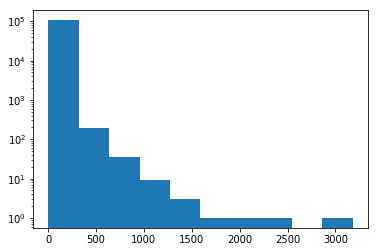

In [63]:
#2.Number of ratings per item 
array = X.getnnz(axis=0)
print(array)
plt.hist(array)
plt.yscale('log', nonposy='clip')

(array([119633.,      0.,  57487.,      0.,      0.,  80891.,      0.,
        174356.,      0., 561123.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

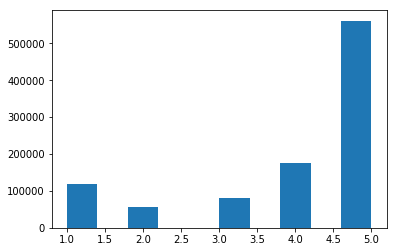

In [64]:
#3.The ratings themselves
#amount of times a certain rating (stars)

ratings = np.array(X[X!=0]).flatten()
plt.hist(ratings)

### 1.3
rubric={reasoning:1}

Use scikit-learn's [NearestNeighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) object (which uses Euclidean distance by default) to find the 5 items most similar to [Brass Grill Brush 18 Inch Heavy Duty and Extra Strong, Solid Oak Handle](https://www.amazon.com/dp/B00CFM0P7Y). 

The code block below grabs the row of `X` associated with the grill brush. The mappers take care of going back and forther between the IDs (like `B00CFM0P7Y`) and the indices of the sparse array (0,1,2,...).

Note: keep in mind that `NearestNeighbors` is for taking neighbors across rows, but here we're working across columns.

In [65]:
grill_brush = "B00CFM0P7Y"
grill_brush_ind = item_mapper[grill_brush]
grill_brush_vec = X[:,grill_brush_ind]

print(url_amazon % grill_brush)

https://www.amazon.com/dp/B00CFM0P7Y


In [66]:
model = NearestNeighbors(metric='euclidean')
model.fit(X.transpose())
Y = model.kneighbors(grill_brush_vec.transpose(), n_neighbors=6)
print(Y)
# print(item_inverse_mapper[93652]) # this is the point itself B00CFM0P7Y

I = 6
for i in range(1, I):
    print(url_amazon % item_inverse_mapper[Y[1][0][i]])

(array([[ 0.        , 74.24284477, 75.14652354, 76.51797175, 76.51797175,
        76.51797175]]), array([[ 93652, 103866, 103865,  98897,  72226, 102810]]))
https://www.amazon.com/dp/B00IJB5MCS
https://www.amazon.com/dp/B00IJB4MLA
https://www.amazon.com/dp/B00EXE4O42
https://www.amazon.com/dp/B00743MZCM
https://www.amazon.com/dp/B00HVXQY9A


### 1.4
rubric={reasoning:1}

Using cosine similarity instead of Euclidean distance in `NearestNeighbors`, find the 5 products most similar to `B00CFM0P7Y`.

In [67]:
model = NearestNeighbors(metric='cosine')
model.fit(X.transpose())
Y = model.kneighbors(grill_brush_vec.transpose(), n_neighbors=6)
print(Y)
# print(item_inverse_mapper[93652]) # this is the point itself B00CFM0P7Y

I = 6
for i in range(1, I):
    print(url_amazon % item_inverse_mapper[Y[1][0][i]])

(array([[0.        , 0.6987374 , 0.72171348, 0.74965277, 0.78953721,
        0.88109454]]), array([[ 93652, 103866, 103867, 103865,  98068,  98066]]))
https://www.amazon.com/dp/B00IJB5MCS
https://www.amazon.com/dp/B00IJB8F3G
https://www.amazon.com/dp/B00IJB4MLA
https://www.amazon.com/dp/B00EF45AHU
https://www.amazon.com/dp/B00EF3YF0Y


### 1.5
rubric={reasoning:2}

For each of the two metrics, compute the compute the total popularity (total stars) of each of the 5 items and report it. Do the results make sense given what we discussed in class about Euclidean distance vs. cosine similarity? 


In [68]:
print("Euclidean similarity")    

model = NearestNeighbors(metric='euclidean')
model.fit(X.transpose())
Y = model.kneighbors(grill_brush_vec.transpose(), n_neighbors=6)
array_stars = np.sum(X, axis=0)
# print(array_stars)
# print(array_stars.shape)
# print(item_inverse_mapper[93652]) # this is the point itself B00CFM0P7Y

I = 6
for i in range(1, I):
    print(array_stars.transpose()[Y[1][0][i]])
    #print(Y[1][0][i])
    
print("Cosine similarity")    
    
model = NearestNeighbors(metric='cosine')
model.fit(X.transpose())
Y = model.kneighbors(grill_brush_vec.transpose(), n_neighbors=6)
array_stars = np.sum(X, axis=0)
# print(array_stars)
# print(array_stars.shape)
# print(item_inverse_mapper[93652]) # this is the point itself B00CFM0P7Y

I = 6
for i in range(1, I):
    print(array_stars.transpose()[Y[1][0][i]])

Euclidean similarity
[[266.]]
[[205.]]
[[5.]]
[[5.]]
[[5.]]
Cosine similarity
[[266.]]
[[438.]]
[[205.]]
[[311.]]
[[513.]]


Cosine loss takes popularity of the item in consideration, so cosine similarity is more likely to find more popular items (as the angle of popular items will be smaller and closer to the query.) Hence it makes sense that we get items that are more popular (more stars, e.g. 513).

For euclidean distance, very small vectors will have a similar distance to the query, which might be "closer" than larger vectors with smaller angles. Thus it makes sense that we get items with 5 stars in our result.

### 1.6
rubric={reasoning:3}

PCA gives us an approximation $X \approx ZW$ where the rows of $Z$ contain a length-$k$ latent feature vectors for each user and the columns of $W$ contain a length-$k$ latent feature vectors for each item.

Another strategy for finding similar items is to run PCA and then search for nearest neighbours with Euclidean distance in the latent feature space, which is hopefully more meaningful than the original "user rating space". In other words, we run nearest neighbors on the columns of $W$. Using $k=10$ and scikit-learn's [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to perform the dimensionality reduction, find the 5 nearest neighbours to the grill brush using this method. You can access $W$ via the `components_` field of the `TruncatedSVD` object, after you fit it to the data. 

Briefly comment on your results.

Implementation note: when you call on `NearestNeighbors.kneighbors`, it expects the input to be a 2D array. There's some weirdness here because `X` is a scipy sparse matrix but your `W` will be a dense matrix, and they behave differently in subtle ways. If you get an error like "Expected 2D array, got 1D array instead" then this is your problem: a column of `W` is technically a 1D array but a column of `X` has dimension $1\times n$, which is technically a 2D array. You can take a 1D numpy array and add an extra first dimension to it with `array[None]`.

Conceptual note 1: We are using the "truncated" rather than full SVD since a full SVD would involve dense $d\times d$ matrices, which we've already established are too big to deal with. And then we'd only use the first $k$ rows of it anyway. So a full SVD would be both impossible and pointless.

Conceptual note 2: as discussed in class, there is a problem here, which is that we're not ignoring the missing entries. You could get around this by optimizing the PCA objective with gradient descent, say using `findMin` from previous assignments. But we're just going to ignore that for now, as the assignment seems long enough as it is (or at least it's hard for me to judge how long it will take because it's new).

In [69]:
svd = TruncatedSVD(n_components=10)
svd.fit(X)
W = svd.components_
Z = svd.transform(X)

reduced_grill_brush = "B00CFM0P7Y"
reduced_grill_brush_ind = item_mapper[grill_brush]
reduced_grill_brush_vec = W[:,grill_brush_ind]

reshaped_reduced_grill_brush_vec = np.reshape(reduced_grill_brush_vec, (-1, 1))

model = NearestNeighbors(metric="euclidean")
model.fit(W.transpose())

Y = model.kneighbors(reshaped_reduced_grill_brush_vec.transpose(), n_neighbors=6)

I = 6
for i in range(1, I):
    print(url_amazon % item_inverse_mapper[Y[1][0][i]])

https://www.amazon.com/dp/B000H1SJ8C
https://www.amazon.com/dp/B000MVLB8W
https://www.amazon.com/dp/B001VNC3Q4
https://www.amazon.com/dp/B000X9BNG8
https://www.amazon.com/dp/B004WB77L8


It recommends grills instead of hand-held grill products, which is still very similar.

## Exercise 2: putting it all together in a CPSC 340 "mini-project"
rubric={reasoning:25}

In this open-ended mini-project, you'll explore the [UCI default of credit card clients data set](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). There are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default payment next month" in the data. The rest of the columns can be used as features. 



**Your tasks:**

1. Download the data set and load it in. Since the data comes as an MS Excel file, I suggest using [`pandas.read_excel`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html) to read it in. See [Lecture 2](https://github.ugrad.cs.ubc.ca/CPSC340-2017W-T2/home/blob/master/lectures/L2.ipynb) for an example of using pandas.
2. Perform exploratory data analysis on the data set. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Randomly split the data into train, validation, test sets. The validation set will be used for your experiments. The test set should be saved until the end, to make sure you didn't overfit on the validation set. You are welcome to use scikit-learn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), which takes care of both shuffling and splitting. 
4. Try scikit-learn's [DummyClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) as a baseline model.
5. Try logistic regression as a first real attempt. Make a plot of train/validation error vs. regularization strength. What’s the lowest validation error you can get?
6. Explore the features, which are described on the UCI site. Explore preprocessing the features, in terms of transforming non-numerical variables, feature scaling, change of basis, etc. Did this improve your results?
7. Try 3 other models aside from logistic regression, at least one of which is a neural network. Can you beat logistic regression? (For the neural net(s), the simplest choice would probably be to use scikit-learn's [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), but you are welcome to use any software you wish. )
8. Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. I won't make it a strict requirement, but I recommend checking out one of the following (the first two are simple scikit-learn tools, the latter two are much more sophisticated algorithms and require installing new packages): 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)
9. Explore feature selection for this problem. What are some particularly relevant and irrelevant features? Can you improve on your original logistic regression model if you first remove some irrelevant features?
10. Take your best model overall. Train it on the combined train/validation set and run it on the test set once. Does the test error agree fairly well with the validation error from before? Do you think you’ve had issues with optimization bias? Report your final test error directly in your README.md file as well as in your report.

**Submission format:**
Your submission should take the form of a "report" that includes both code and an explanation of what you've done. You don't have to include everything you ever tried - it's fine just to have your final code - but it should be reproducible. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code.

**Assessment:**
We plan to grade and fairly leniently. We don't have some secret target accuracy that you need to achieve to get a good grade. You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results. For example, if you write something like, "And then I noticed the model was overfitting, so I decided to stop using regularization" - then, well, that's not good. If you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

**And...**
This style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-6 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, don't do it out of perfectionism... do it because you're learning and enjoying it.



# 1.

 We downloaded the data and used pandas to read it in as a dataframe.

In [70]:
filename = "credit_card_data.xls"

with open(os.path.join("..", "data", filename), "rb") as f:
    credit_card = pd.read_excel(f)
    
credit_card.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


# 2.

Average age of credit card client.

In [71]:
age = credit_card["X5"]
age = age.drop(age.index[0])
age.mean()

35.4855

Average payment delay for each credit card client.

In [72]:
payments = credit_card[["X6", "X7", "X8", "X9", "X10"]]
payments = payments.drop(payments.index[0])
avgOnTimenessPerUser = payments.mean(axis=1)
avgOnTimenessPerUser.mean(axis=0)

-0.16070666666666436

Bar graph of amount of male vs female clients.

/home/trevin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


([<matplotlib.axis.XTick at 0x7f99c734da20>,
 <a list of 2 Text xticklabel objects>)

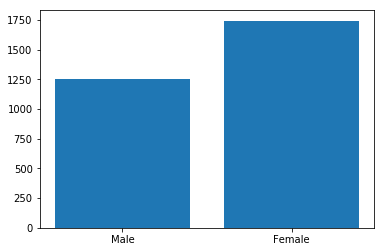

In [73]:
payments = credit_card[["X6", "X7", "X8", "X9", "X10"]]
payments = payments.drop(payments.index[0])
avgOnTimenessPerUser = payments.mean(axis=1)
gender = credit_card["X2"]
#print(gender)
reshaped_gender = np.reshape(gender, (-1, 1))
#print(reshaped_gender.shape)
array_sex = reshaped_gender[:,0]
count_m = 0;
for i in range (3000):
    if (array_sex[i] == 1):
        count_m = count_m + 1
count_male = count_m
count_female = 3000-count_male

y = [count_male, count_female]
N = len(y)
x = range(N)
LABELS = ["Male", "Female"]
width = 1/2
plt.bar(x, y, width, color="blue")

plt.bar(x, y, align='center')
plt.xticks(x, LABELS)

#fig = plt.gcf()
#plot_url = py.plot_mpl(fig, filename='mpl-basic-bar')

Bar graph of martial status to amount of clients.

[['MARRIAGE']
 [1]
 [2]
 ...
 [2]
 [1]
 [1]]
40


/home/trevin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


([<matplotlib.axis.XTick at 0x7f99c7324358>,
 <a list of 3 Text xticklabel objects>)

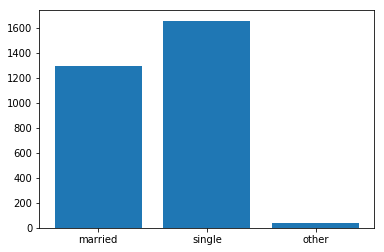

In [74]:
marrital_status = credit_card["X4"]
#print(marrital_status)
reshaped_marital_status = np.reshape(marrital_status, (-1, 1))
print(reshaped_marital_status)
array_marital_status = reshaped_marital_status[:,0]
count_m = 0;
count_s = 0;
count_o = 0;
for i in range (3000):
    if (array_marital_status[i] == 3):
        count_o = count_o + 1    
    if (array_marital_status[i] == 1):
        count_m = count_m + 1
    if (array_marital_status[i] == 2):
        count_s = count_s + 1

count_married = count_m
count_single = count_s
count_other = count_o

print(count_other)

y = [count_married, count_single, count_other]
N = len(y)
x = range(N)
LABELS = ["married", "single", "other"]
width = 1/2
plt.bar(x, y, width, color="blue")

plt.bar(x, y, align='center')
plt.xticks(x, LABELS)

# 3 and 4

We split the data into training, validation and test sets, then used the DummyClassifier to fit on the training data and reported the validation error by predicting on the validation set.

In [75]:
# Split the data 
from sklearn.model_selection import train_test_split
y = credit_card["Y"]
y = y.drop(y.index[0])

dropped_credit_card = credit_card.drop(credit_card.index[0]) # drops the first row describing the columns

X_train, X_test, y_train, y_test = train_test_split(dropped_credit_card, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.40, random_state=42)

y_train=y_train.astype('int') 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
baselineModel = dc.fit(X=X_train, y=y_train, sample_weight=None)

y_hat = dc.predict(X_val)
error = np.mean(y_hat != y_val)
print("Validation error for dummy classifier:")
print(error)

(14400, 24) (14400,)
(6000, 24) (6000,)
Validation error for dummy classifier:
0.34739583333333335


# 5.

We generated an array of regularization strengths that differ exponentially, and then calculated the validation error for each regularization strength. We then plotted the regularization strengths to validation error. The lowest validation error we got was 0.22502.

In [76]:
from sklearn.linear_model import LogisticRegression
from math import ceil
lr = LogisticRegression()
logisticRegressionModel = lr.fit(X=X_train, y=y_train, sample_weight=None)

min_irs = 1
step_size = 1
max_irs = 10 + step_size
inverse_regularization_strengths = np.arange(min_irs, max_irs, step_size) 
inverse_regularization_strengths = 2 ** inverse_regularization_strengths;
regularization_strengths = 1 / inverse_regularization_strengths;
values = int(ceil((max_irs - min_irs) / step_size))
validation_errors = np.zeros(values)
i = 0

for rs in regularization_strengths:
    lr.C = rs
    print(lr.C)
    lr.fit(X=X_train, y=y_train, sample_weight=None)
    y_hat = lr.predict(X_val)
    error = np.mean(y_hat != y_val)
    validation_errors[i] = error
    i += 1

0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625


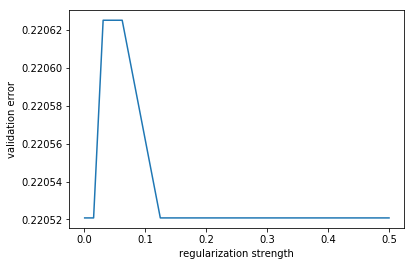

In [77]:
#print(validation_errors)
#print(values)
#print(regularization_strengths)
plt.plot(regularization_strengths, validation_errors)
plt.ylabel("validation error")
plt.xlabel("regularization strength")
plt.show()

# 6

We scaled the matrix and the validation error stayed the same.

In [78]:
from sklearn.linear_model import LogisticRegression
from math import ceil
lr = LogisticRegression()
logisticRegressionModel = lr.fit(X=X_train, y=y_train, sample_weight=None)
y_hat = lr.predict(X_val)
error = np.mean(y_hat != y_val)
print("Validation error for logistic regression classifier:")
print(error)

from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train, with_mean=False)
#print(X_scaled)

lr = LogisticRegression()
logisticRegressionModel = lr.fit(X=X_train, y=y_train, sample_weight=None)
y_hat = lr.predict(X_val)
error = np.mean(y_hat != y_val)
print("Validation error for scaled logistic regression classifier:")
print(error)

Validation error for logistic regression classifier:
0.220625
Validation error for scaled logistic regression classifier:
0.220625


# 7

We ran a Random Forest model, a Neural Network model and a KNN model. The Random Forest classifier gave us our lowest validation error of 0.0, which is very odd - however, we were unable to figure out why. The Neural Network classifier gave us a validation error of 0.27010, as well as the KNN classifier, which also seemed a bit strange.

In [79]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=23)
rf.fit(X_train, y_train)

y_hat = rf.predict(X_val)
error = np.mean(y_hat != y_val)
print("Validation error for random forest classifier:")
print(error)

Validation error for random forest classifier:
0.0


In [80]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X=X_train, y=y_train)

y_hat = mlp.predict(X_val)
error = np.mean(y_hat != y_val)
print("Validation error for neural network classifier:")
print(error)

Validation error for neural network classifier:
0.27010416666666665


In [81]:
from sklearn.neighbors import KNeighborsClassifier
knnc = KNeighborsClassifier()
knnc.fit(X=X_train, y=y_train)

y_hat = mlp.predict(X_val)
error = np.mean(y_hat != y_val)
print("Validation error for k nearest neighbors classifier:")
print(error)

Validation error for k nearest neighbors classifier:
0.27010416666666665


# 8

We optimized alpha and momentum for the Neural Network model by generating random values for them and running RandomizedSearchCV on them. After that, we ran the Neural Network model again with the optimized parameters. We got a lower validation error of 0.23114.

In [82]:
from sklearn.model_selection import RandomizedSearchCV
import scipy
from scipy.stats import uniform as sp_rand

param_grid = {'alpha': sp_rand(), 'momentum': sp_rand()}
rs = RandomizedSearchCV(estimator=mlp, param_distributions=param_grid, n_iter=10)

X_train_ndarray = X_train.as_matrix()
y_train_ndarray = y_train.as_matrix()
rs.fit(X_train, y_train)

y_hat = rs.predict(X_val)
error = np.mean(y_hat != y_val)
print("Validation error for mlp with optimized parameters classifier:")
print(error)

Validation error for mlp with optimized parameters classifier:
0.23114583333333333


# 9

We dropped sex and martial status in the hopes that our features would be more relevant to the model, but the validation error remained the same.

In [83]:
X_train_dropped = X_train.drop(['X2', 'X4'], axis=1)
X_val_dropped = X_val.drop(['X2', 'X4'], axis=1)

from sklearn.linear_model import LogisticRegression
from math import ceil
lr = LogisticRegression()
logisticRegressionModel = lr.fit(X=X_train_dropped, y=y_train, sample_weight=None)
y_hat = lr.predict(X_val_dropped)
error = np.mean(y_hat != y_val)
print("Validation error for logistic regression classifier:")
print(error)

Validation error for logistic regression classifier:
0.22052083333333333


# 10

We used the Random Forest model from before and trained it on the combined train/validation set, then used it to predict the test set. It also got a test error of 0.0, which we also found odd.

In [84]:
Xframes = [X_train, X_val]
X_combined = pd.concat(Xframes)

yframes = [y_train, y_val]
y_combined = pd.concat(yframes)

X_combined=X_combined.astype('int') 
y_combined=y_combined.astype('int') 

bestModel = rf.fit(X=X_combined, y=y_combined)

y_hat = rf.predict(X_test)
error = np.mean(y_hat != y_test)
print("Test error for random forest classifier:")
print(error)

Test error for random forest classifier:
0.0


## Exercise 3: Very short answer questions
rubric={reasoning:7}

1. Why is it difficult for a standard collaborative filtering model to make good predictions for new items?
2. Consider a fully connected neural network with layer sizes (10,20,20,5); that is, the input dimensionality is 10, there are two hidden layers each of size 20, and the output dimensionality is 5. How many parameters does the network have, including biases?
3. Why do we need nonlinear activation functions in neural networks?
4. Assuming we could globally minimize the neural network objectve, how does the depth of a neural network affect the fundamental trade-off?
5. List 3 forms of regularization we use to prevent overfitting in neural networks.
6. Assuming we could globally minimize the neural network objectve, how would the size of the filters in a convolutational neural network affect the fundamental trade-off?
7. Why do people say convolutional neural networks just a special case of a fully-connected (regular) neural networks? What does this imply about the number of learned parameters?


# Answers

1. Because it depends on similar users having an opinion on that item - new items dont have this<br>
2. (11)(21)(21)(5) = 24,255 <br>
3. Because, otherwise it's just a linear model <br>
4. The deeper the neural network is: the more the training error decreases, and the less the training error approximates the test error. (overfits) <br>
5. Weight decay, early stopping, and dropout <br>
6. If the filter size is smaller - the number of parameters is fewer: which reduces overfitting, increasing the training error, but making the training error a better approximation of the test error <br>
7. because it reduces the size of the matrix - proves that we dont need all the parameters <br>